In [2]:
import pandas as pd
train_x_df = pd.read_csv('data/train_x_df.csv')
train_y_df = pd.read_csv('data/train_y_df.csv')
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


## 100번 샘플

In [222]:
sample_id = 100
X_train = train_x_df[train_x_df.sample_id==sample_id][['time', 'close']]
y_train = train_y_df[train_y_df.sample_id==sample_id][['time', 'close']]
X_train.index = X_train.time
y_train.index = y_train.time
X_train.head()

,time,close
time,,
0,0,0.944003
1,1,0.944115
2,2,0.944003
3,3,0.944563
4,4,0.944339


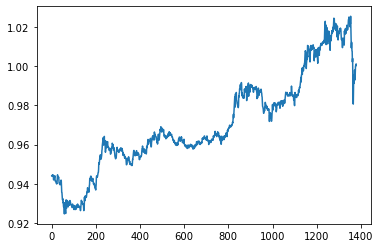

In [223]:
import matplotlib.pyplot as plt
plt.plot(X_train.time, X_train.close)
plt.show()

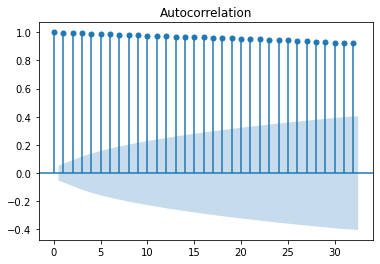

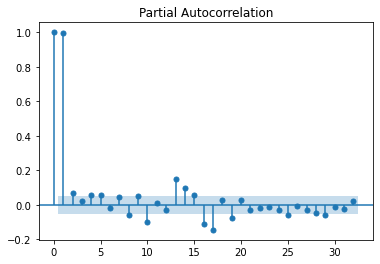

In [224]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(X_train.close)
plot_pacf(X_train.close)
plt.show()

## 차분

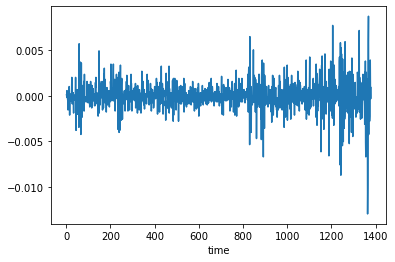

In [225]:
# 차분 후의 정상성 확인 
integrated_price = X_train.close.diff(1)
integrated_price.plot();

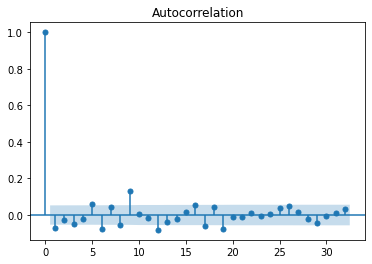

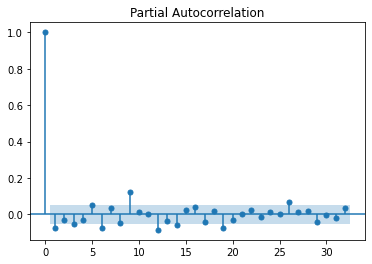

In [226]:
plot_acf(integrated_price[1:])
plot_pacf(integrated_price[1:])
plt.show()

## ARIMA modeling

In [246]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(X_train.close, order=(5, 1, 5))
arima_fit = arima.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1380
Model:                 ARIMA(5, 1, 5)   Log Likelihood                6972.478
Date:                Wed, 05 May 2021   AIC                         -13922.956
Time:                        19:29:13   BIC                         -13865.436
Sample:                             0   HQIC                        -13901.437
                               - 1380                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3652      0.078     -4.687      0.000      -0.518      -0.212
ar.L2         -0.0608      0.163     -0.373      0.709      -0.380       0.259
ar.L3         -0.6892      0.123     -5.624      0.000      -0.929      -0.449
ar.L4         -0.1630      0.119     -1.369      0.171      -0.396       0.070
ar.L5          0.1384      0.156      0.889      0.374      -0.167       0.443
ma.L1          0.2991      0.081      3.672      0.000       0.139       0.459
ma.L2          0.0022      0.170      0.013      0.990      -0.331       0.336
ma.L3          0.6423      0.126      5.112      0.000       0.396       0.889
ma.L4          0.0797      0.132      0.604      0.546      -0.179       0.338
ma.L5         -0.1199      0.165     -0.726      0.468      -0.443       0.204
sigma2      2.375e-06   4.84e-08     49.026      0.000    2.28e-06    2.47e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5942.33
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.13   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.91e+17. Standard errors may be unstable.
"""

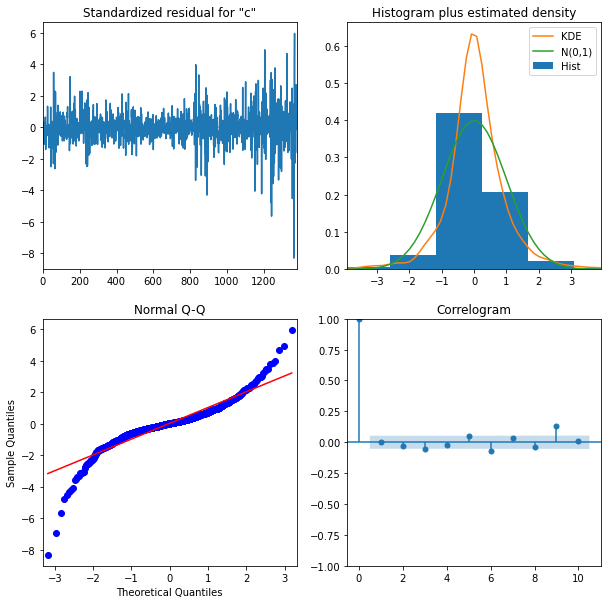

In [232]:
arima_fit.plot_diagnostics(figsize=(10, 10));

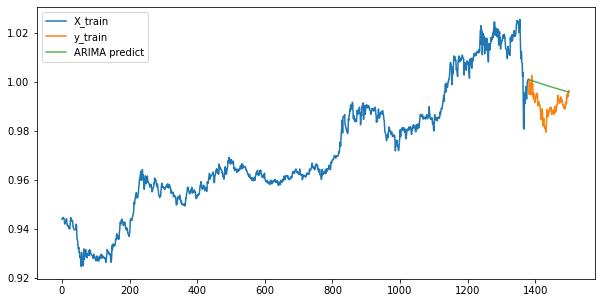

In [233]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 1380), X_train.close, label='X_train')
plt.plot(np.arange(1380, 1500), y_train.close, label='y_train')
plt.plot(arima_fit.predict(start=1380, end=1500), label='ARIMA predict', alpha=0.8)
plt.legend();